In [58]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import brentq, newton

In [59]:
# === Precio del call según Black-Scholes ===
def bs_call(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))  # Cálculo de d1 (formulazo)
    d2 = d1 - sigma * np.sqrt(T)  # Cálculo de d2 (formulazo)

    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  # Precio del call (BS)

# === Griegas del call ===
def greeks_call(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    nd1 = norm.pdf(d1)  # Densidad normal en d1 N(d1)

    # Formulazo de cada Griega
    Delta = norm.cdf(d1)
    Vega  = S * nd1 * np.sqrt(T)
    Theta = -(S * nd1 * sigma / (2 * np.sqrt(T))) - (r * K * np.exp(-r * T) * norm.cdf(d2))
    Gamma = nd1 / (S * sigma * np.sqrt(T))
    Rho = K * T * np.exp(-r*T) * norm.cdf(d2)

    return dict(Delta=Delta, Vega=Vega, Theta=Theta, Gamma=Gamma, Rho=Rho)  # Devuelve diccionario con griegas

# === Bull Spread (compra call K1, vende call K2) ===
def bull_spread_price(S, r, sigma, T, K1, K2):
    return bs_call(S, K1, r, sigma, T) - bs_call(S, K2, r, sigma, T)

# === Griegas del Bull Spread ===
def bull_spread_greeks(S, r, sigma, T, K1, K2):
    g1 = greeks_call(S, K1, r, sigma, T)
    g2 = greeks_call(S, K2, r, sigma, T)
    return {k: g1[k] - g2[k] for k in g1}

# === Payoff al vencimiento del Bull Spread ===
def bull_spread_payoff(ST, K1, K2):
    return np.maximum(ST - K1, 0) - np.maximum(ST - K2, 0)

# === Monte Carlo ===
def mc_bull_spread(S0, r, sigma, T, K1, K2, n_sims=100000, seed=42):
    np.random.seed(seed)
    Z = np.random.standard_normal(n_sims)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    payoff = bull_spread_payoff(ST, K1, K2)

    return ST, np.exp(-r * T) * payoff

# Black-Scholes
def bs_price(S, K, r, T, sigma, option='call'):
    if sigma <= 0 or T <= 0:
        # Límite: precio intrínseco descontado
        if option == "call":
            return max(0.0, S - K*np.exp(-r*T))
        else:
            return max(0.0, K*np.exp(-r*T) - S)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option.lower() == "call":
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# === Volatilidad implicita del activo ===
def implied_vol(price_mkt, S, K, r, T, option="call", brent_bounds=(1e-6, 5.0), tol=1e-8, maxiter=100):
    # Verificación de límites teóricos: el precio debe estar entre [intrínseco, cota superior]
    if option == "call":
        lower = max(0.0, S - K*np.exp(-r*T))
        upper = S
    else:
        lower = max(0.0, K*np.exp(-r*T) - S)
        upper = K*np.exp(-r*T)
        
    if not (lower - 1e-12 <= price_mkt <= upper + 1e-12):
        raise ValueError(f"Precio de mercado fuera de rango teórico [{lower:.4f}, {upper:.4f}]")

    # Función objetivo
    def f(sig):
        return bs_price(S, K, r, T, sig, option) - price_mkt

    a, b = brent_bounds
    fa, fb = f(a), f(b)

    # Ajusta el extremo superior si no cambia de signo
    if fa * fb > 0:
        # intenta expandir b
        for b_try in [10.0, 15.0, 25.0, 50.0]:
            fb = f(b_try)
            if fa * fb <= 0:
                b = b_try
                break

    # Intenta método de Brent
    try:
        iv = brentq(f, a, b, xtol=tol, maxiter=maxiter)
        return iv
    except Exception:
        pass

    # Si Brent falla, intenta método de Newton
    seed = min(max(sigma_hist if 'sigma_hist' in globals() and np.isfinite(sigma_hist) else 0.2, 1e-3), 2.0)
    try:
        iv = newton(lambda s: f(s), seed, fprime=lambda s: bs_vega(S, K, r, T, s), tol=tol, maxiter=maxiter)
        if iv > 0:
            return iv
    except Exception:
        pass

    raise RuntimeError("No se pudo encontrar una volatilidad implícita con los métodos intentados.")

In [60]:
# === Parámetros de ejemplo ===

ticker = 'ORCL'
prices = yf.download(ticker, start = '2015-01-01', end = '2025-09-18', progress=False)['Close']
returns = prices.pct_change().dropna()

sigma_hist = (returns.std() * np.sqrt(252))[0]  # volatilidad histórica anualizada
S0 = prices.iloc[-1][0]  # precio actual del activo
r = 0.05 # tasa libre de riesgo anual
T = 1  # tiempo hasta el vencimiento en años

K1, K2 = 350, 400  # strikes de compra y venta

C:\Users\samue\AppData\Local\Temp\ipykernel_27152\3967016226.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start = '2015-01-01', end = '2025-09-18', progress=False)['Close']
C:\Users\samue\AppData\Local\Temp\ipykernel_27152\3967016226.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_hist = (returns.std() * np.sqrt(252))[0]  # volatilidad histórica anualizada
C:\Users\samue\AppData\Local\Temp\ipykernel_27152\3967016226.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = prices.iloc[-1][0]  # precio actual del activo


In [61]:
stock = yf.Ticker(ticker)

opt_chain = stock.option_chain('2026-09-18')

calls = opt_chain.calls

call_k1 = calls[calls['strike'] == K1]

price_k1 = float(call_k1['lastPrice'])

imp_vol = implied_vol(price_k1, S0, K1, r, T, option="call", brent_bounds=(1e-6, 5.0), tol=1e-8, maxiter=100)

price_bs = bull_spread_price(S0,r,T,imp_vol,K1,K2)
price_bs

C:\Users\samue\AppData\Local\Temp\ipykernel_27152\3189237781.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_k1 = float(call_k1['lastPrice'])


np.float64(12.42510025846802)

In [62]:
# === Precio teórico ===
price_bs = bull_spread_price(S0,r,T,sigma_hist,K1,K2)
price_bs

np.float64(12.814809612531121)

In [63]:
# === Griegas del Bull Spread ===
greeks   = bull_spread_greeks(S0,r,T,sigma_hist,K1,K2)
greeks

{'Delta': np.float64(0.0945332621980689),
 'Vega': np.float64(1.2811499281165055),
 'Theta': np.float64(-2.8214289346068426),
 'Gamma': np.float64(4.506561640993563e-05),
 'Rho': np.float64(4.907714840256059)}

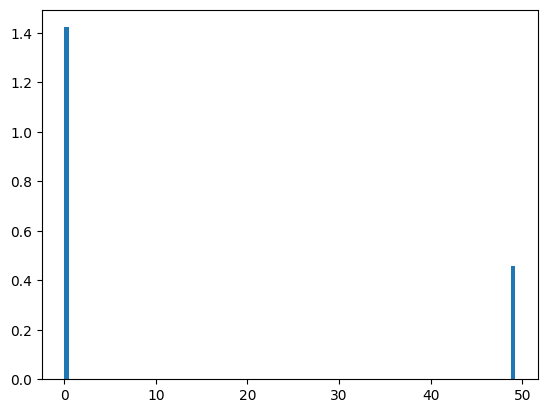

In [64]:
# === Monte Carlo ===
ST, mc = mc_bull_spread(S0,r,T,sigma_hist,K1,K2,n_sims=200000)

plt.hist(mc, bins=100, density=True)
plt.show()

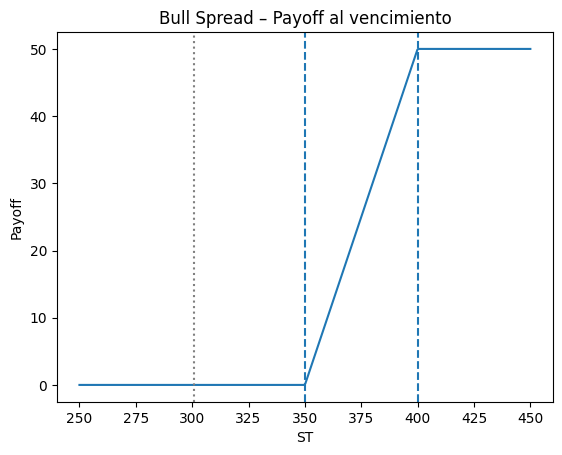

In [65]:
# === Curva de payoff teórico al vencimiento ===
ST_grid = np.linspace(250, 450, 400)
payoff_curve = bull_spread_payoff(ST_grid, K1, K2)

plt.figure()
plt.plot(ST_grid, payoff_curve)
plt.axvline(K1, linestyle="--")
plt.axvline(K2, linestyle="--")
plt.axvline(S0, color="gray", linestyle=":")
plt.title("Bull Spread – Payoff al vencimiento")
plt.xlabel("ST")
plt.ylabel("Payoff")
plt.show()